# Model simulations

- Simulating model M2c on a given patient

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import matplotlib.pyplot as plt

from new_patient_model import build_pm_model_from_dataframes, extract_data_from_tables_new,\
        run_model, plot_data, plot_runs, calculate_errors, split_train_test,\
        plot_runs_area

from find_map import fit_model_map, pybobyqa_wrapper

from simplified_models import model_desc_m2c, build_pm_model_m2c, initialization_fn_m2c_2,\
          param_names_m2c, param_bounds_m2b, param_bounds_m2c, generate_dosing_component_m2


## Load data

In [2]:
blood_counts = pd.read_csv('../patient_data_venex/blood_counts_table.csv')
bm_blasts = pd.read_csv('../patient_data_venex/blasts_table.csv')
cycle_days = pd.read_csv('../patient_data_venex/cycle_days.csv')

In [3]:
patient_id = 3360
cycle_info_3360, leuk_table_3360, blast_table_3360 = extract_data_from_tables_new(blood_counts,
                                                                             bm_blasts, cycle_days, patient_id, use_neut=True)

## Fit model m2c on patient 3360

In [4]:
te_model, pm_model = build_pm_model_from_dataframes(cycle_info_3360, leuk_table_3360, blast_table_3360,
            use_neut=True, use_b0=True,
            model_desc=model_desc_m2c,
            build_model_function=build_pm_model_m2c,
            initialization=initialization_fn_m2c_2,
            dosing_component_function=generate_dosing_component_m2,
            params_to_fit=param_names_m2c,
            uniform_prior=True,
            use_initial_guess=True,
            )

In [ ]:
map_params = fit_model_map(pm_model, params_to_fit=param_names_m2c, maxeval=50000,
                                   method=pybobyqa_wrapper,
                                   bounds=param_bounds_m2c + [(0, 10), (0, 10)],
                                   options={'maxfun':20000})

In [6]:
print(map_params)

[0.26987975197654174, 0.4519978202898991, 1.9448714092834245, 1.439501460545996, 4.125809961267499, 0.5859902307345868, 1.0900642328504613, 0.800163763007402, 0.036374517313301116, 0.13613399879052993, 0.4533844044740751]


In [7]:
map_params = [0.26987975197654174, 0.4519978202898991, 1.9448714092834245, 1.439501460545996, 4.125809961267499, 0.5859902307345868, 1.0900642328504613, 0.800163763007402, 0.036374517313301116, 0.13613399879052993, 0.4533844044740751]

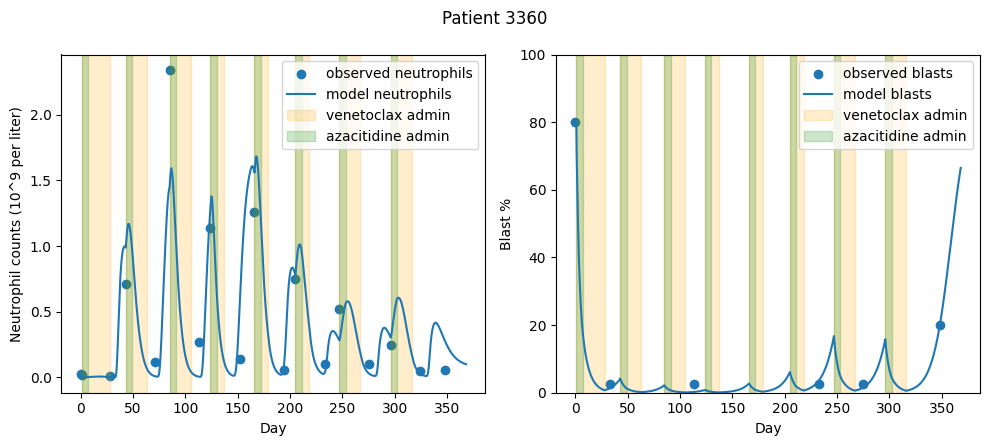

In [8]:
max_time = max(cycle_info_3360.days_ven_stop.max(), leuk_table_3360.days_lab.max(), blast_table_3360.days_from_bm.max()) + 20
results = run_model(te_model, map_params, n_samples=max_time*20, max_time=max_time, params_to_fit=param_names_m2c,
                    initialization=initialization_fn_m2c_2)
plot_data(results, cycle_info_3360, leuk_table_3360, blast_table_3360, patient_id, save_fig=True, use_neut=True)

In [9]:
# calculate errors for this patient
neut_corr, blast_corr, results = calculate_errors(te_model, map_params, cycle_info_3360, leuk_table_3360, blast_table_3360,
                                                   params_to_fit=param_names_m2c, wbc_only=False, use_neut=True,
                                                   initialization=initialization_fn_m2c_2, error_fn='corrcoef')

In [10]:
print(neut_corr, blast_corr)

0.8879162303986801 0.9993093564115775


In [11]:
fvu = 1 - neut_corr**2
print(fvu)

0.21160476779459814


In [12]:
# Save results
results_table = pd.DataFrame(results)
results_table.columns = ['time', 'Xneut', 'Xblasts_obs']
results_table.to_csv('3360_m2c_optimized_results.tsv', sep='\t', index=None)